In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import re
from D_Age_Technologies import *
from I_CompanySize_Technology import clean_technology
from E_Salary_Cities import *

sns.set_style("white")
sns.set_palette('viridis')

DATA_PATH_2020 = '../Dataset/2020.csv'
DATA_PATH_2019 = '../Dataset/2019.csv'
DATA_PATH_2018 = '../Dataset/2018.csv'

df_2018 = pd.read_csv(DATA_PATH_2018)
df_2019 = pd.read_csv(DATA_PATH_2019)
df_2020 = pd.read_csv(DATA_PATH_2020)

TECHNOLOGY = 'Your main technology / programming language'
AGE = 'Age'
AGE_SEGMENT = 'age_segment'

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def merge(data_frames, common_columns=[]):
    return pd.concat(data_frames, ignore_index=True)[common_columns]

In [3]:
# Merge the 2019 and 2020 datasets on common columns
merged_df = merge(data_frames=[df_2019, df_2020], common_columns=[AGE, TECHNOLOGY])
print('Total number of rows', merged_df.shape[0])
assert merged_df.shape[0] == df_2019.shape[0] + df_2020.shape[0]

Total number of rows 2244


<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> State & Refine QS</h1></div>

In [4]:
# Question may be interesting to business. When an IT company knows the distribution between age and languages, and they're in a need to immediatly hire employees on a project, it can know which age segment mostly work with such language, so it can target within. <br><br>

# >| There may be some languages that arose at very early time and that its users are old people who may be not up-to-date or still using old langauages. | |_`Matches`_ |

> #### _`QS:`_ What is the most preferred language/technology for each age segment? 
>|Set Expectation | Collect Info | Match Results| 
>|----|----|----|
>|Question is answerbale, there's a suffiecient number of rows having both age and technology as not nons.|Only 136 rows out of 2244 rows for the age is missing. 141 rows out of 2244 rows for the technology is missing.|_`Matches`_ There are a few rows that have missing values for both age and technology, which indicates that we still have sufficient data available to answer the question.

<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> Explore Data</h1></div>

## Univariate Analysis: Age

In [5]:
# Explore the portion of missing data in age column
print('Number of Age missing rows', sum(merged_df[AGE].isna()))
print('Percentage of Age missing', 100*sum(merged_df[AGE].isna())/merged_df[AGE].shape[0], '%')

Number of Age missing rows 136
Percentage of Age missing 6.0606060606060606 %


In [6]:
# Explore the mean, min, max, quartiles of the age column
statistics_df = merged_df.loc[:, [AGE]].describe()
mode_df = merged_df.loc[:, [AGE]].mode().rename(index={0: 'mode'})
statistics_df = pd.concat([statistics_df, mode_df]).transpose()
print("Central Tendancy and Spread of Age:")
statistics_df

Central Tendancy and Spread of Age:


,count,mean,std,min,25%,50%,75%,max,mode
Age,2108.0,32.470588,5.498379,20.0,29.0,32.0,35.0,69.0,30.0


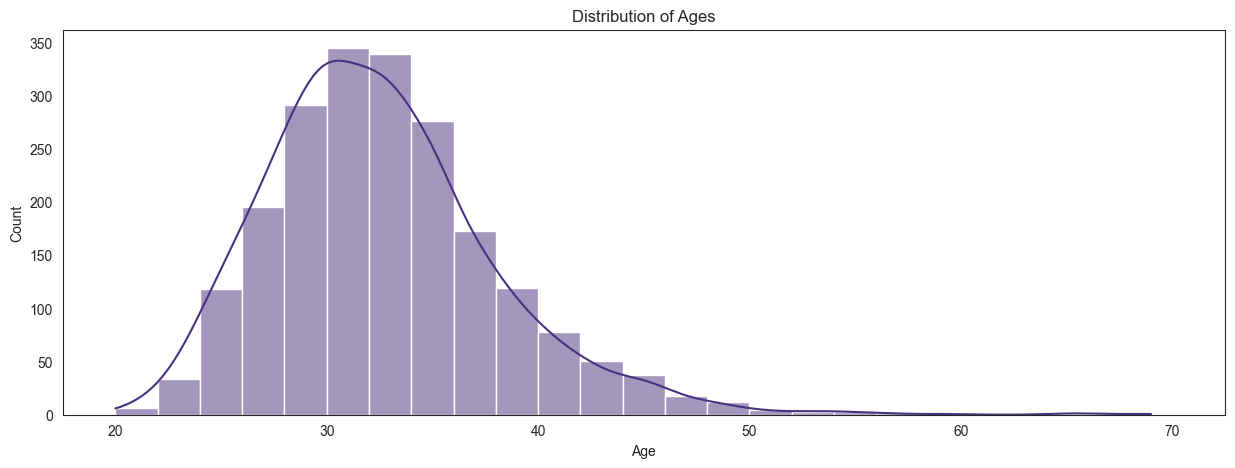

In [7]:
# Distribution of age for employees who worked in IT and submitted the form
plt.figure(figsize=(15, 5))
sns.histplot(data=merged_df[AGE], kde=True, binwidth=2)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')
plt.show()

### Imputing missing Age values

- Impute the missing values with mode. Because it's significantly repeated, 49.5% of form responders are in their 30s. 
- Although the mode is very close to the mean, it's chosen for imputation. This is because the mean is slightly right shifted by the very few old ages(outliers), however, the mode is not affected by them.

In [8]:
age_mode=mode_df.loc['mode', AGE]
merged_df[AGE] = merged_df[AGE].fillna(age_mode)
assert sum(merged_df[AGE].isna()) == 0

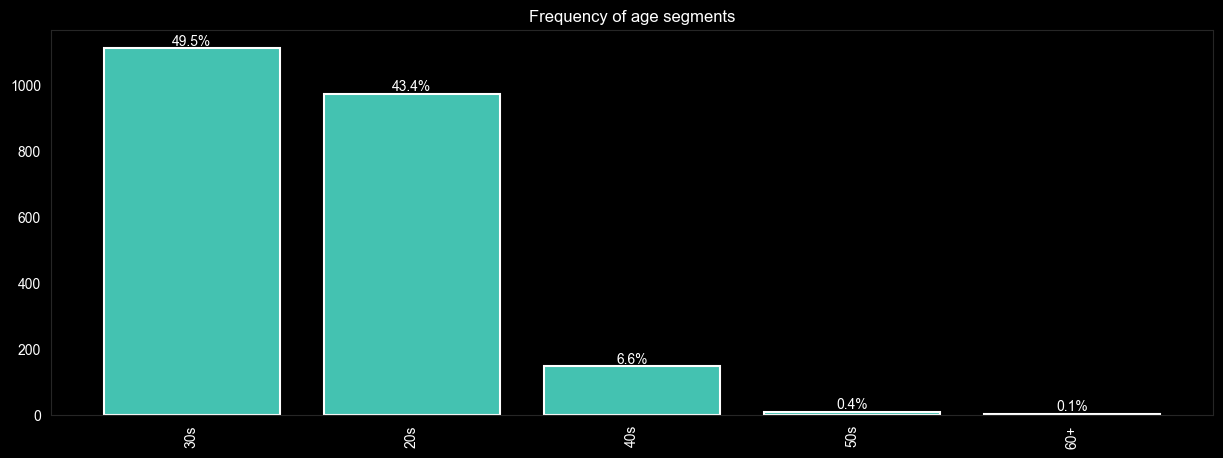

In [9]:
df_seg = segment_age(merged_df, 
                        age_segments=['20s', '30s', '40s', '50s', '60+'],
                        age_ranges=[20, 30, 40, 50, 60, 120])

plot_single_histogram(df_seg, AGE_SEGMENT, 'Frequency of age segments', figsize=(15, 5))

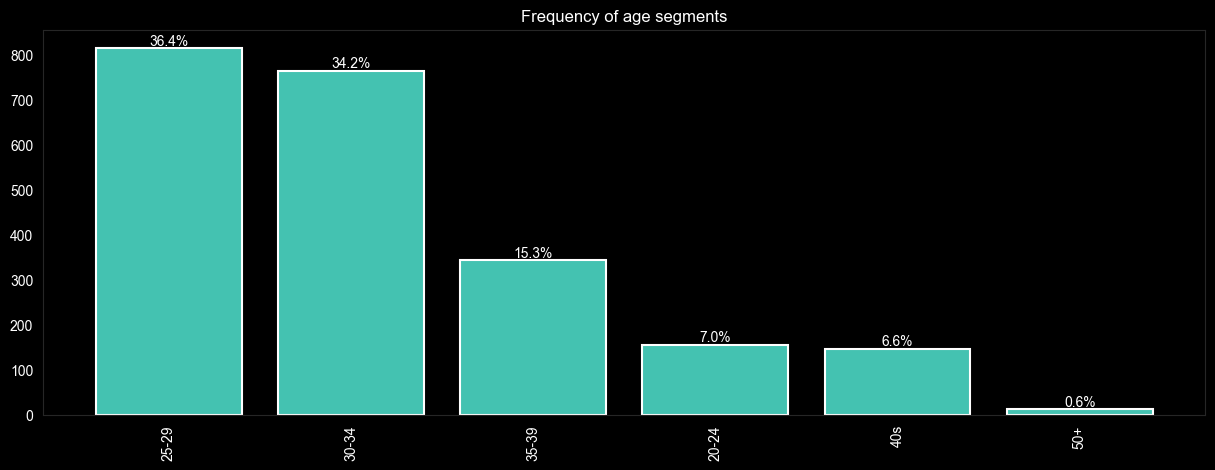

In [10]:
merged_df = segment_age(merged_df, 
                        age_segments=['20-24', '25-29', '30-34', '35-39', '40s', '50+'], 
                        age_ranges=[20, 25, 30, 35, 40, 50, 120])
plot_single_histogram(merged_df, AGE_SEGMENT, 'Frequency of age segments', figsize=(15, 5))

> |Expectation|Collected|Match?|
> |:----|:----|:----|
> |The question is feasible to answer and the data exhibits a balanced distribution across the age groups of 20s, 30s, 40s. <br><br> Therefore, we can analyze and provide insights for each age group individually.|92.8% of the responders are within their 20s and 30s, only 6.6% are at their 40s. | The 40s age segment is not represented suffieciently. It seems that people at their 40s don't engage much in such surveys. <br><br>To address this issue and ensure more reliable analysis, we will divide the survey responders into more specific age segments by grouping them into intervals of five years each. This will allow us to have more groups to study the question on. ❌|
> |Suffiecent rows for employees in their 50s| Only 0.4% of the respondents fall into the age group of 50s.|This low percentage collected makes sense, because employees in their 50s may not be as familiar with or inclined to fill out online surveys.❌|
> |People above 60 years are more likely to be retired.| Retirment age in germany is 65 (and 7 months)  |_`Matches`_ |
> |There’s should be no teen-ager or child because this is an IT salary, and people below 20 very few of them are hired in the IT industry.|Youngest age was 20, no year below.|_`Matches`_ |

## Univariate Analysis: Langauages and Technologies

In [11]:
# Explore the portion of missing data in age column
print('Number of technology missing rows', sum(merged_df[TECHNOLOGY].isna()))
print('Percentage of technology missing', 100*sum(merged_df[TECHNOLOGY].isna())/merged_df[TECHNOLOGY].shape[0])

Number of technology missing rows 141
Percentage of technology missing 6.283422459893048


In [12]:
# Statistics about the technology
unique_technologies = merged_df[TECHNOLOGY].unique()
print("Number of unique langauages: ", len(unique_technologies))
print("Most repeated technology among IT Employees: ", merged_df.loc[:, [TECHNOLOGY]].mode().iloc[0,0])

Number of unique langauages:  275
Most repeated technology among IT Employees:  Python


> |Expectation|Collected|Match?|
> |:----|:----|:----|
> | Around 30 languages because its only 2244 responders who have filled the survey.| There exist 275 unique languages. | This is because it’s a survey, where people write in a text field the languages and technologies they are using. Hence, one may write in such field many technologies separated by ‘,’ or ‘/’ <br><br> Also, there may be misspellings and inconsistencies writing a language. for example, one may write ‘Javascript’ or ‘javascript’ or even ‘JS’. <br><br> To address consistency and misspelling issues, a string matching solution was applied. The Levenshtein Distance was utilized to measure the differences between the expected technology and the technology mentioned by the respondents. ❌|

In [13]:
cleaned_df = clean_technology(merged_df, TECHNOLOGY, filter=10)
unique_technologies = cleaned_df[TECHNOLOGY].unique()
print("After data cleaning and inforcing consistency\nNumber of unique langauges: ", len(unique_technologies))

After data cleaning and inforcing consistency
Number of unique langauges:  26


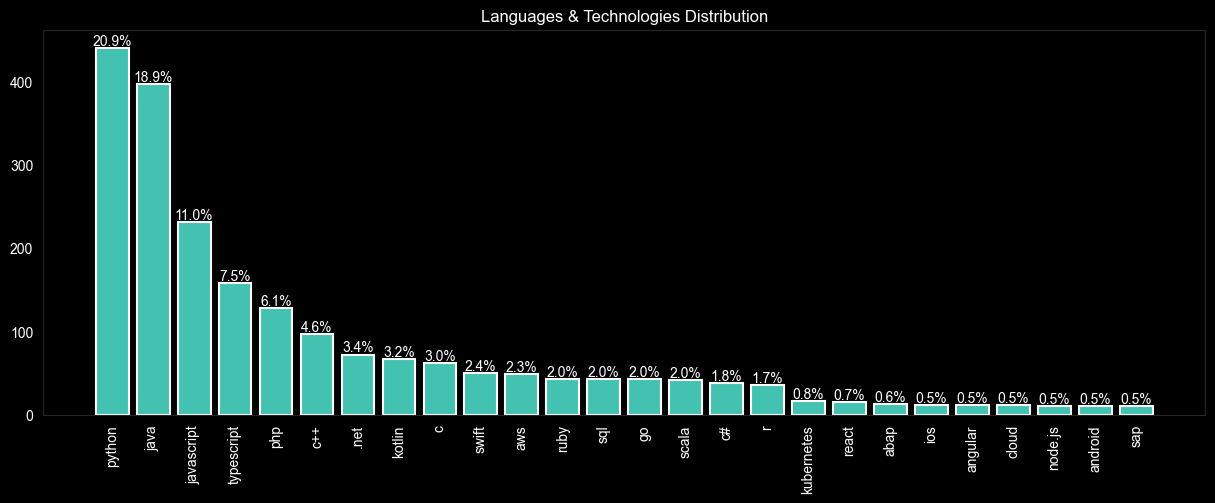

In [14]:
# Distribution of Technologies for employees who worked in IT and submitted the form
plot_single_histogram(cleaned_df, TECHNOLOGY, 'Languages & Technologies Distribution', figsize=(15, 5))

> |Expectation|Collected|Match?|
> |:----|:----|:----|
> | Based on a study conducted in May 2019 regarding the most popular coding languages among unicorns, the distribution of languages in the survey is expected to align with the findings of the study. The study can be found at this link: https://flyaps.com/blog/top-10-coding-languages-used-by-global-companies/ | Computing a histogram of the langauges filled by survey responders |_`Matches`_ |

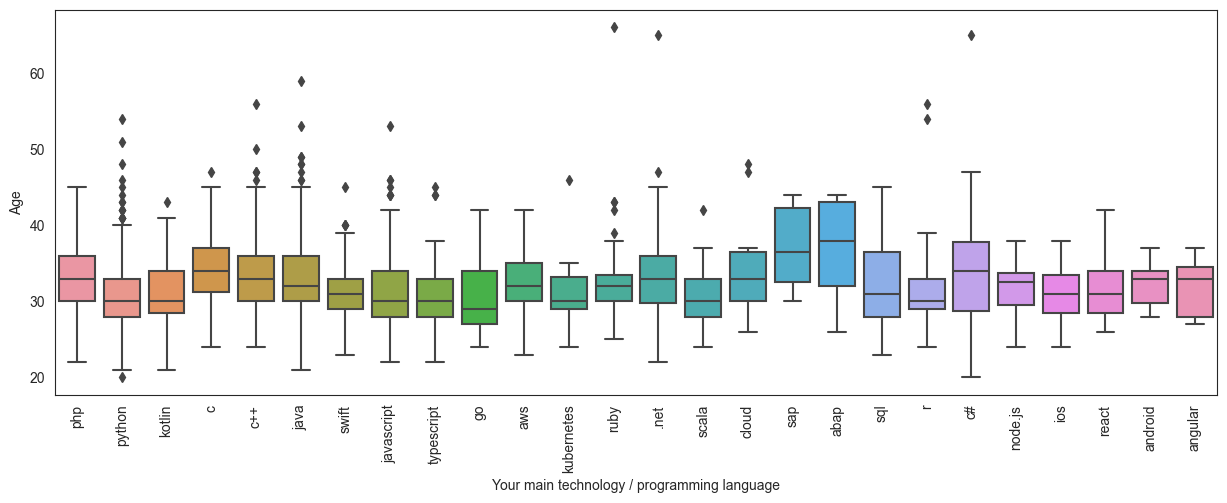

In [15]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=TECHNOLOGY, y=AGE, data=cleaned_df)
plt.xticks(rotation=90)
plt.show()

> ***
> ### _`Interpretations:`_
> - _`The median of most technologies lies within the 30s, this is obvious since most survey repsonders are at their 30s`_ 
>- _`The IQR for SAP and ABAP is around the 35-40s, this makes sense since SAP was started in 1972 and SAP ABAP was created in 1983 for the development of business applications in the SAP environment. Thus more elder employees knows and uses SAP ABAP`_

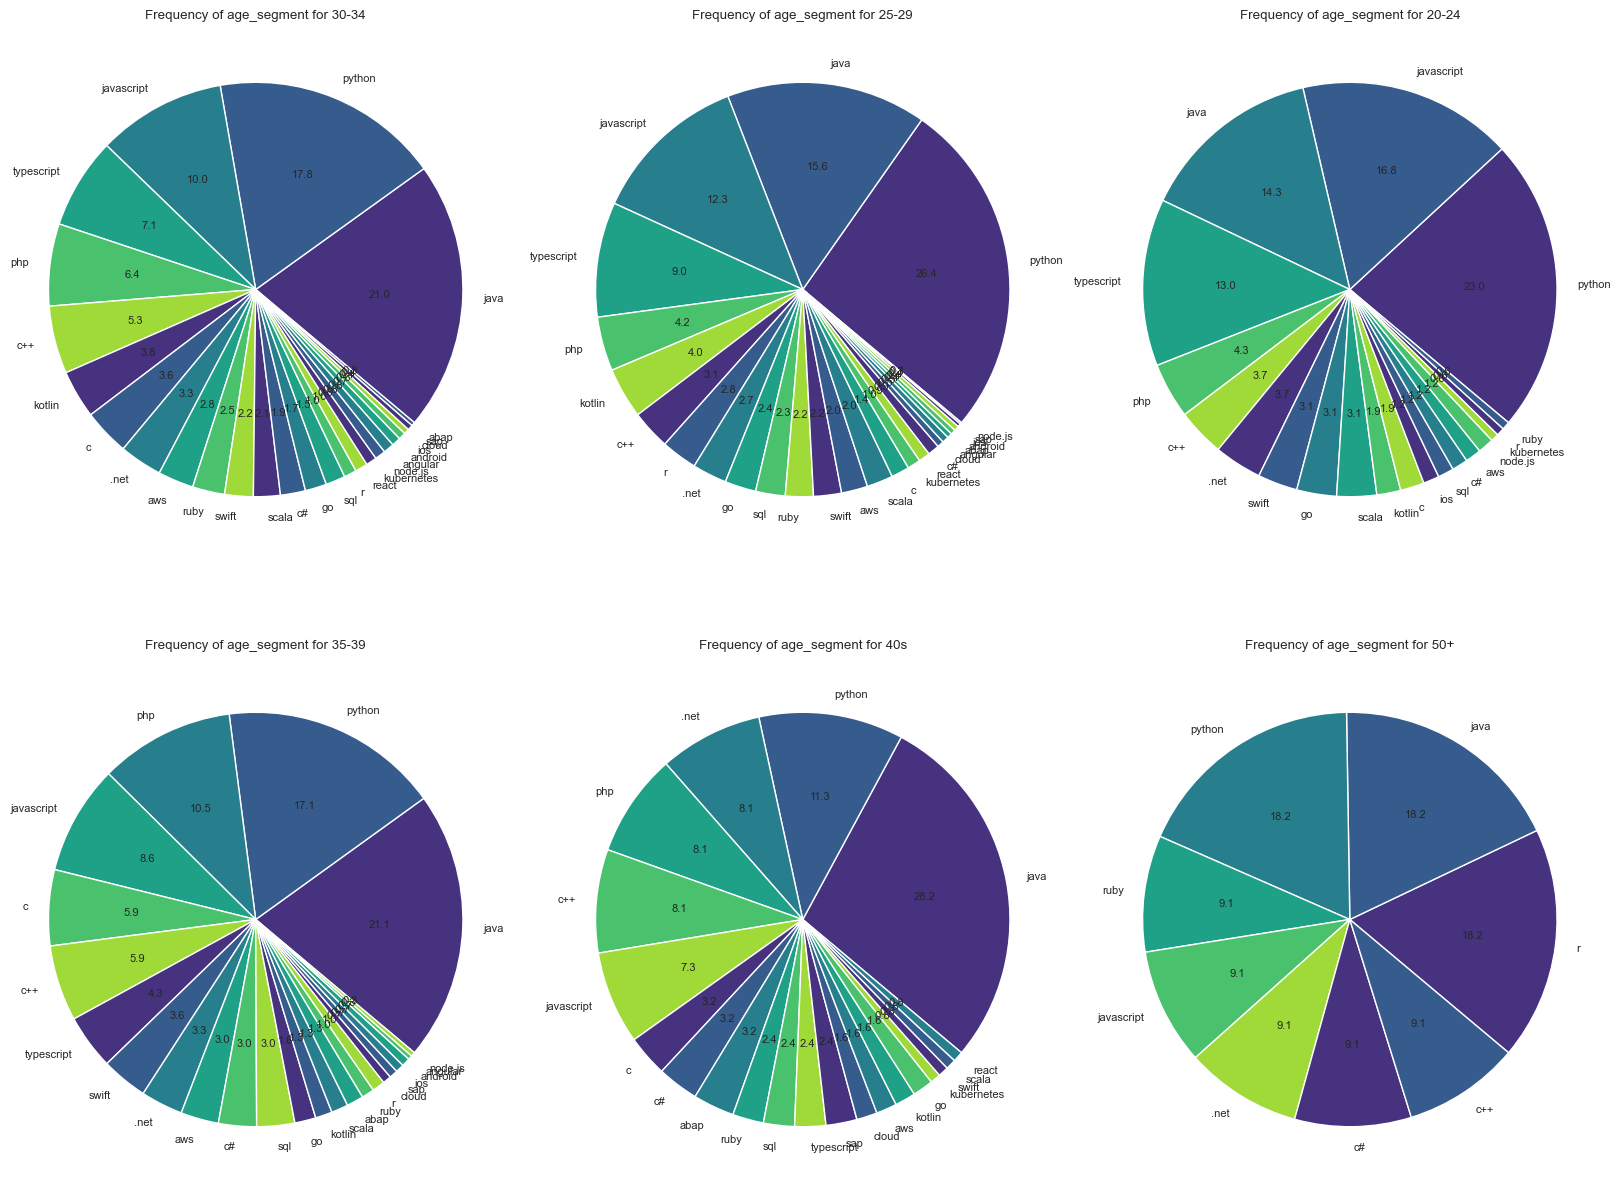

In [16]:
plot_pie_charts(cleaned_df, analysis_column=AGE_SEGMENT, division_column=TECHNOLOGY)

> ***
> ### _`Interpretations:`_
> - _`Python and Java are popular among all age segments.`_ 
>- _`Type script is popular among 20s, less popular in the ages from 30-35, and Even very less popular for 35+, this makes sense since typescript was released in 2012. Thus eldery age won't be much familiar with it.`_ 
>- _`Based on the data provided, we can observe that the usage of PHP and .Net varies across different age groups. The usage of PHP shows a pattern of 8.1% in the 40s, 10.5% in the 35-39 age group, 6.4% in the 30-34 age group, 4.3% in the 25-29 age group, and 4.2% in the 20-24 age group. Similarly, the usage of .Net exhibits a trend of 8.1% in the 40s, 3.3% in both the 35-39 and 30-34 age groups, 2.7% in the 25-29 age group, and 3.7% in the 20-24 age group. From this analysis, it can be concluded that PHP and .Net are relatively more popular among individuals in their late 30s and 40s compared to other age segments. `_ 


<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> Build Models</h1></div>

In [17]:
# Group by 'age_segment' and find the most frequent category in 'technology'
most_repeated_categories = []
for age_segment, group in cleaned_df.groupby(AGE_SEGMENT):
    most_frequent_category = group[TECHNOLOGY].mode().values
    most_repeated_categories.append({AGE_SEGMENT: age_segment, 'Most Popular Technology': most_frequent_category})

# Create a new DataFrame with the most repeated categories for each age segment
result_df = pd.DataFrame(most_repeated_categories)

# Print the resulting DataFrame
display(result_df)

,age_segment,Most Popular Technology
0,20-24,[python]
1,25-29,[python]
2,30-34,[java]
3,35-39,[java]
4,40s,[java]
5,50+,"[java, python, r]"


<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> Interpret Results</h1></div>

> ***
> ### _`Interpretations:`_
> - _`PHP, Python, etc existed with a significant amount within each group segment, due to the popularity and different usages of such langauages.`_ 
>- _`Analyzing the usage of TypeScript, a language that emerged relatively recently, we observe that it is more prevalent among older individuals who may be less up-to-date with newer languages. This suggests that older individuals might be inclined to stick with older languages they are familiar with, rather than adopting newer technologies.`_
>- _`This observation can be supported by the notion that younger individuals are generally more adaptable and open to learning new technologies. Their flexibility and ability to quickly grasp new concepts may make them more inclined to explore and embrace emerging languages.`_
>- _`The above analysis demonstrates that the distribution of langauges within each age segment differs, however, the **most popular langauage** within each age segment doesn't depend on a specific age segment. The most popular are nearly the same across all age segments.`_

<div style="border-width:1; border-radius: 15px; border-style: solid; border-color: rgb(10, 10, 10); background-color: #316B83; text-align: center;font: 14pt 'Candara';font-weight:bold;"><h1> Communicate Results</h1></div>

>- _`Python and Java emerge as the most popular technologies based on the analysis. For individuals venturing into the IT field, these languages serve as excellent starting points due to their high demand and widespread usage.`_
>- _`The most popular langauage that you are encouraged to start learning in the field will not differ according to your age very much. They most popular are nearly the same across all age segments.`_
